# Post-Disaster Damage Estimation from Satellite Images (End-to-End)

This notebook walks you through a **from-scratch** prototype for (near) real-time post‑disaster damage estimation using satellite images.

**What you'll get here:**
- Environment setup (installs + imports)
- Load *your* pre/post disaster GeoTIFFs **or** run with synthetic sample data (no downloads needed)
- Simple change detection baseline (no ML)
- U‑Net segmentation model (deep learning) — minimal training loop
- Inference and damage map visualization
- Export results as GeoTIFF

> Tip: Start with the **synthetic demo** to confirm the pipeline runs. Then switch to your real imagery by editing the paths in the "Load your own data" section.


## Quickstart

1. **Run the cell below** to install packages (only once per environment).
2. **Restart the kernel** (Jupyter → Kernel → Restart).
3. Run cells top to bottom. If you don't have data yet, use the **synthetic demo** section.


In [1]:
try:
    import rasterio, geopandas
    import torch, torchvision
except Exception as _:
    %pip install -q rasterio geopandas shapely opencv-python matplotlib
    %pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cpu
    %pip install -q segmentation-models-pytorch albumentations pytorch-lightning


In [3]:
import os, math, json, time, sys, gc, warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Geospatial
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optional (segmentation models); will import lazily later
try:
    from segmentation_models_pytorch import Unet
    _has_smp = True
except Exception:
    _has_smp = False
    print("[Info] segmentation-models-pytorch not found. We'll use a tiny UNet defined in-notebook.")

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Torch:", torch.__version__)


Python: 3.13.5
NumPy: 2.1.3
Torch: 2.8.0+cpu


## Utility: helpers

In [4]:
def normalize_img(img):
    img = img.astype(np.float32)
    m = img.max()
    if m <= 0:
        m = 1.0
    return img / m

def show_side_by_side(a, b, titles=("A", "B"), figsize=(12,5)):
    fig, axs = plt.subplots(1,2, figsize=figsize)
    axs[0].imshow(np.moveaxis(a,0,-1))
    axs[0].set_title(titles[0])
    axs[0].axis('off')
    axs[1].imshow(np.moveaxis(b,0,-1))
    axs[1].set_title(titles[1])
    axs[1].axis('off')
    plt.show()

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)


## Option A: Load **your own** pre/post disaster GeoTIFFs

Place your files under a folder like `data/` and set the paths below.

> Expected format: multi-band GeoTIFFs (e.g., 3 bands for RGB). If your images have more bands, you can pick any subset (e.g., [1,2,3]).


In [5]:
# >>> EDIT THESE PATHS if you have your own data
pre_path  = "data/pre_disaster.tif"
post_path = "data/post_disaster.tif"

use_rgb_bands = [1,2,3]   # choose the bands to read (1-indexed)

def try_load_user_data(pre_path, post_path, bands):
    if not (os.path.exists(pre_path) and os.path.exists(post_path)):
        print("[Info] No local GeoTIFFs found at:", pre_path, post_path)
        return None, None, None
    with rasterio.open(pre_path) as src_pre:
        pre_img = src_pre.read(bands)  # [C,H,W]
        profile = src_pre.profile
    with rasterio.open(post_path) as src_post:
        post_img = src_post.read(bands)
    return pre_img, post_img, profile

user_pre, user_post, user_profile = try_load_user_data(pre_path, post_path, use_rgb_bands)
if user_pre is not None:
    print("Loaded your data:", user_pre.shape, user_post.shape)
else:
    print("Proceeding with Synthetic Demo (Option B) — you can switch back anytime by adding your files.")


[Info] No local GeoTIFFs found at: data/pre_disaster.tif data/post_disaster.tif
Proceeding with Synthetic Demo (Option B) — you can switch back anytime by adding your files.


## Option B: **Synthetic Demo** (no downloads needed)

This section procedurally creates two small "satellite-like" images where the **post** image has simulated damage: a few buildings removed/altered and a flood patch added. This lets you run the entire pipeline right away.


In [6]:
def make_synthetic_scene(H=512, W=512, seed=42):
    rng = np.random.default_rng(seed)
    # Base: green-ish land, blue-ish water strip
    base = np.zeros((3,H,W), dtype=np.float32)
    base[1] = 0.4 + 0.05 * rng.normal(size=(H,W))  # green
    base[2] += 0.1 * rng.random((H,W))             # blue tint
    
    # Add a few "buildings" as bright rectangles
    for _ in range(30):
        h, w = rng.integers(10, 40), rng.integers(10, 40)
        y, x = rng.integers(0, H-h), rng.integers(0, W-w)
        color = 0.8 + 0.2 * rng.random(3)
        base[:, y:y+h, x:x+w] = np.clip(color[:,None,None], 0, 1)
    return base

def apply_damage(pre_img, seed=43):
    rng = np.random.default_rng(seed)
    post = pre_img.copy()
    H, W = pre_img.shape[1:]
    # Remove/alter some building rectangles (simulate destruction)
    for _ in range(12):
        h, w = rng.integers(10, 40), rng.integers(10, 40)
        y, x = rng.integers(0, H-h), rng.integers(0, W-w)
        # turn to dark rubble
        post[:, y:y+h, x:x+w] = np.array([0.2, 0.2, 0.2])[:,None,None]
    # Add a "flood" patch (bluish overlay)
    fy, fx = rng.integers(100, 300), rng.integers(100, 300)
    fh, fw = rng.integers(80, 150), rng.integers(80, 150)
    post[2, fy:fy+fh, fx:fx+fw] += 0.3  # more blue
    post = np.clip(post, 0, 1)
    return post

if user_pre is None:
    pre_img  = (make_synthetic_scene()*3000).astype(np.uint16)
    post_img = (apply_damage(pre_img.astype(np.float32)/3000)*3000).astype(np.uint16)
    profile = {
        'driver':'GTiff', 'height':pre_img.shape[1], 'width':pre_img.shape[2],
        'count':3, 'dtype':'uint16', 'crs':None, 'transform':from_origin(0,0,1,1)
    }
else:
    pre_img, post_img, profile = user_pre, user_post, user_profile

print("Working shapes:", pre_img.shape, post_img.shape)


Working shapes: (3, 512, 512) (3, 512, 512)


### Visualize Pre vs Post

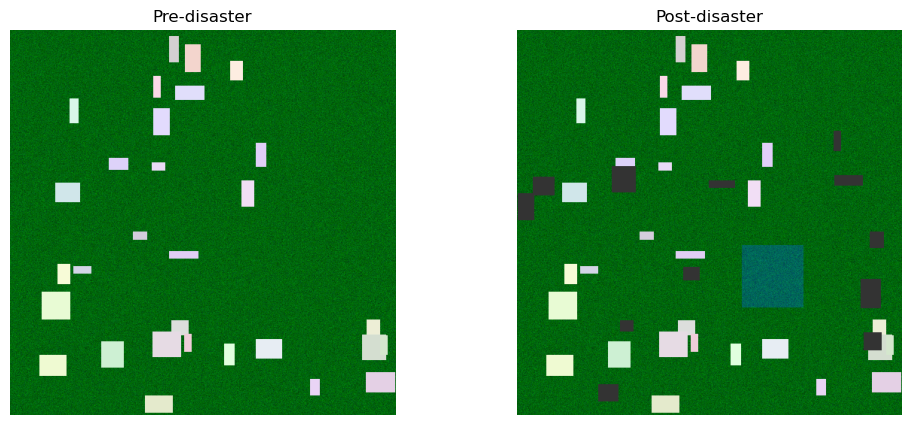

In [7]:
pre_v  = normalize_img(pre_img)
post_v = normalize_img(post_img)
show_side_by_side(pre_v, post_v, titles=("Pre-disaster", "Post-disaster"))


## Baseline: Absolute Difference Change Map

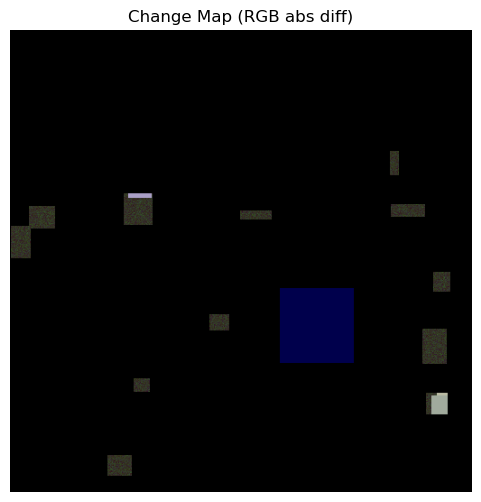

In [8]:
diff = np.abs(pre_v - post_v)
plt.figure(figsize=(6,6))
plt.imshow(np.moveaxis(diff,0,-1))
plt.title("Change Map (RGB abs diff)")
plt.axis('off')
plt.show()


## Prepare Tiles (for model input/train/infer)

In [9]:
def make_chips(pre, post, size=256, stride=256):
    H, W = pre.shape[1], pre.shape[2]
    chips = []
    for i in range(0, H - size + 1, stride):
        for j in range(0, W - size + 1, stride):
            pre_c  = pre[:, i:i+size, j:j+size]
            post_c = post[:, i:i+size, j:j+size]
            chips.append(((i,j), pre_c, post_c))
    return chips

chips = make_chips(pre_v, post_v, size=256, stride=256)
len(chips)


4

## Model: U-Net (tiny fallback defined here if needed)

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=6, n_classes=2, base=16):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.mid   = DoubleConv(base*2, base*4)
        self.up1   = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec1  = DoubleConv(base*4, base*2)
        self.up2   = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec2  = DoubleConv(base*2, base)
        self.outc  = nn.Conv2d(base, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        m  = self.mid(p2)
        u1 = self.up1(m)
        c1 = torch.cat([u1, d2], dim=1)
        d  = self.dec1(c1)
        u2 = self.up2(d)
        c2 = torch.cat([u2, d1], dim=1)
        d  = self.dec2(c2)
        return self.outc(d)

# Choose model
if _has_smp:
    model = Unet(encoder_name="resnet34", encoder_weights=None, in_channels=6, classes=2)
else:
    model = TinyUNet(in_ch=6, n_classes=2, base=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
sum(p.numel() for p in model.parameters()), device


(24445922, device(type='cpu'))

## Create a Synthetic Ground-Truth Change Mask (demo only)

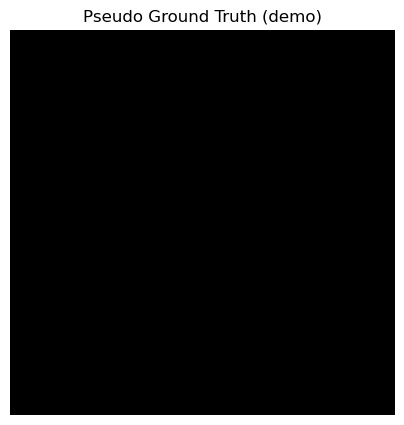

In [11]:
# Use the abs-diff as a proxy to create a pseudo label (for demonstration)
# Threshold the grayscale of diff
gray = diff.mean(axis=0)
th = np.percentile(gray, 85)  # top 15% as 'damaged'
mask = (gray >= th).astype(np.int64)  # 1=damaged, 0=not

plt.figure(figsize=(5,5))
plt.imshow(mask, cmap='gray')
plt.title('Pseudo Ground Truth (demo)')
plt.axis('off')
plt.show()


## Minimal Dataset & DataLoader

In [12]:
class ChangeDataset(Dataset):
    def __init__(self, pre, post, mask, tile=256, stride=256):
        self.samples = []
        H, W = pre.shape[1:]
        for i in range(0, H - tile + 1, stride):
            for j in range(0, W - tile + 1, stride):
                pre_c  = pre[:, i:i+tile, j:j+tile]
                post_c = post[:, i:i+tile, j:j+tile]
                m      = mask[i:i+tile, j:j+tile]
                self.samples.append((pre_c, post_c, m))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        pre_c, post_c, m = self.samples[idx]
        x = np.concatenate([pre_c, post_c], axis=0)  # [6,H,W]
        return torch.from_numpy(x).float(), torch.from_numpy(m).long()

dataset = ChangeDataset(pre_v, post_v, mask, tile=256, stride=256)
loader  = DataLoader(dataset, batch_size=2, shuffle=True)

len(dataset)


4

## Train (very short demo — a few iterations)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2  # increase for better results
model.train()
for ep in range(epochs):
    losses = []
    for x, y in loader:
        x = x.to(device)  # [B,6,H,W]
        y = y.to(device)  # [B,H,W]
        logits = model(x) # [B,2,H,W]
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {ep+1}/{epochs} | loss={np.mean(losses):.4f}")


Epoch 1/2 | loss=1.0705
Epoch 2/2 | loss=0.7635


## Inference on the Full Scene

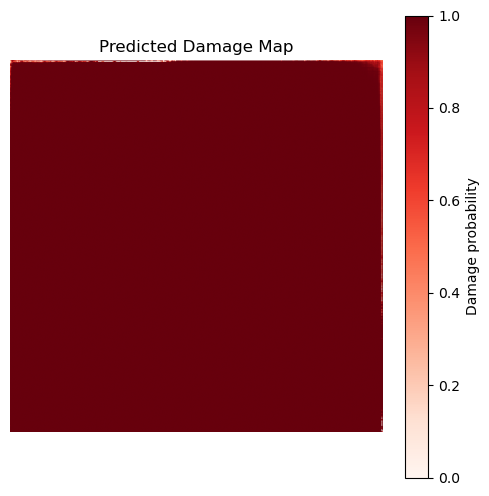

In [14]:
model.eval()
with torch.no_grad():
    x_full = torch.from_numpy(np.concatenate([pre_v, post_v], axis=0)[None]).float().to(device)
    logits = model(x_full)  # [1,2,H,W]
    prob_damage = torch.softmax(logits, dim=1)[0,1].cpu().numpy()

plt.figure(figsize=(6,6))
plt.imshow(prob_damage, cmap='Reds')
plt.colorbar(label='Damage probability')
plt.title('Predicted Damage Map')
plt.axis('off')
plt.show()


## Export Damage Map to GeoTIFF

In [17]:
out_dir = 'outputs'; ensure_dir(out_dir)
out_tif = os.path.join(out_dir, 'damage_map.tif')

# Use spatial metadata if available (user data) else a dummy geotransform
transform = profile.get('transform', from_origin(0,0,1,1))
crs = profile.get('crs', None)

with rasterio.open(
    out_tif, 'w',
    driver='GTiff', height=prob_damage.shape[0], width=prob_damage.shape[1],
    count=1, dtype='float32', crs=crs, transform=transform
) as dst:
    dst.write(prob_damage.astype('float32'), 1)

print('Saved GeoTIFF ->', out_tif)


Saved GeoTIFF -> outputs\damage_map.tif


## Next Steps (recommended)
- Replace synthetic demo with **your real pre/post GeoTIFFs** (edit `pre_path` and `post_path`).
- Use **building footprints** (e.g., from OpenStreetMap) and aggregate per-building damage scores.
- Train with real labels (e.g., **xBD / xView2** datasets) instead of the synthetic pseudo-mask.
- Add SAR (Sentinel‑1) bands for all‑weather capability.
- Automate ingestion via STAC/SentinelHub and trigger inference when fresh "post" imagery arrives.
